# Validation of Burgers solver against Cole-Hopf transformation

The Burgers equation

$$
\frac{\partial u}{\partial t} + \frac{1}{2} \frac{\partial u^2}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

can also be solved by first solving a heat equation

$$
\frac{\partial v}{\partial t} = \nu \frac{\partial^2 v}{\partial x^2}
$$

and then applying the Cole-Hopf transformation

$$
u = -2 \nu \frac{\partial}{\partial x} \ln v
$$

This notebook compares the solution of the Burgers equation with the solution of the heat equation followed by the Cole-Hopf transformation.

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [7]:
import exponax as ex

In [8]:
burgers_stepper = ex.stepper.Burgers(1, 2 * jnp.pi, 100, 0.01, diffusivity=0.001)
diffusion_stepper = ex.stepper.Diffusion(1, 2 * jnp.pi, 100, 0.01, diffusivity=0.001)

In [9]:
grid = ex.make_grid(1, 2 * jnp.pi, 100)

In [10]:
u_0_heat = 1.5 - (jnp.exp(-10 * (grid - jnp.pi) ** 2) + 0.1)

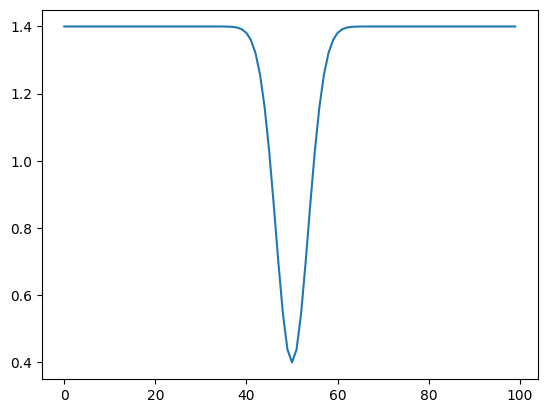

In [12]:
plt.plot(u_0_heat[0])

In [14]:
# u_0_burgers = - 2 * burgers_stepper.diffusivity * exponax.spectral_derivative(jnp.log(u_0_heat), L=2 * jnp.pi, order=1)
u_0_burgers = (
    -2
    * burgers_stepper.diffusivity
    * ex.derivative(jnp.log(u_0_heat), 2 * jnp.pi, order=1)
)

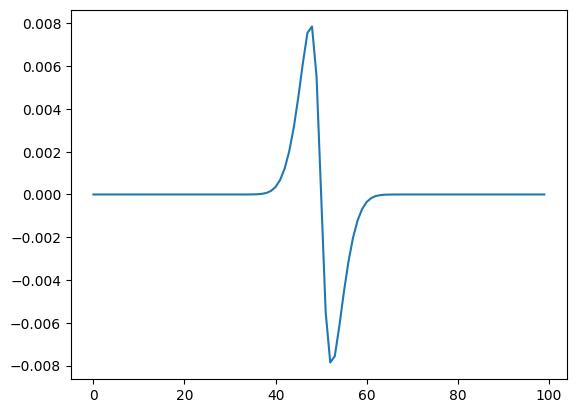

In [16]:
plt.plot(u_0_burgers[0])

In [17]:
heat_trj = ex.rollout(diffusion_stepper, 5000, include_init=True)(u_0_heat)

In [18]:
heat_trj.shape

(5001, 1, 100)

In [20]:
burgers_trj_from_heat = (
    -2
    * burgers_stepper.diffusivity
    * jax.vmap(lambda u: ex.derivative(u, 2 * jnp.pi))(jnp.log(heat_trj))
)

In [21]:
burgers_trj = ex.rollout(burgers_stepper, 5000, include_init=True)(u_0_burgers)

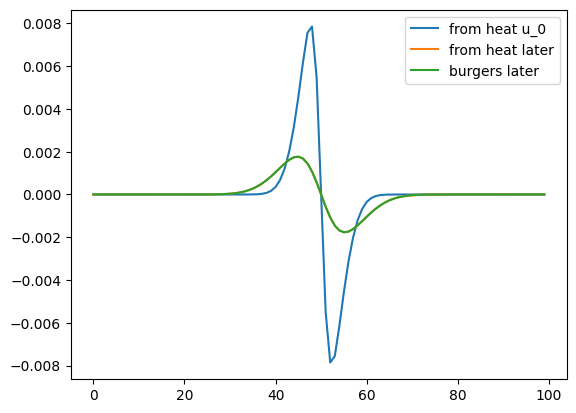

In [23]:
plt.plot(burgers_trj_from_heat[0, 0, :], label="from heat u_0")
plt.plot(burgers_trj_from_heat[5000, 0, :], label="from heat later")
plt.plot(burgers_trj[5000, 0, :], label="burgers later")
plt.legend()

In [24]:
diff_trj = burgers_trj - burgers_trj_from_heat

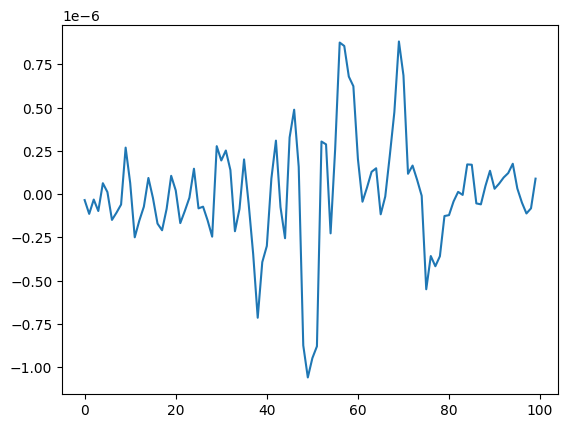

In [26]:
plt.plot(diff_trj[-1, 0, :])